In [1]:
# 下载数据已完成
# import fiftyone as fo
# import fiftyone.zoo as foz
# dataset = fo.zoo.load_zoo_dataset("coco-2017",dataset_dir =r'D:\pytorch\pytorch_data')

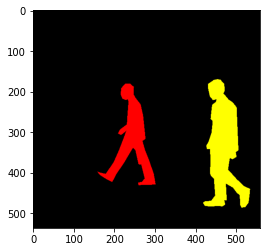

In [15]:
#查看mask
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from PIL import Image
import matplotlib.pyplot  as plt
mask=Image.open(r'D:\pytorch\pytorch_data\PennFudanPed\PedMasks\FudanPed00001_mask.png')
mask=mask.convert("P")
mask.putpalette([0,0,0,
                 255,0,0,
                 255,255,0,
                 255,153,0,])
plt.imshow(mask)
plt.show()

In [3]:
mask_path=r'D:\pytorch\pytorch_data\PennFudanPed\PedMasks\FudanPed00001_mask.png' 
mask = Image.open(mask_path)
mask = np.array(mask)
# instances are encoded as different colors
obj_ids = np.unique(mask)     #mask一共有三个元素构成[0,1,2]
# first id is the background, so remove it
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set
# of binary masks
masks = mask == obj_ids[:, None, None] #分别提取两个objcet的mask

# get bounding box coordinates for each mask
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i]) #返回mask非零坐标，结果为2个（x\y轴）数组，数组组合对应非零元素的坐标位置，也可用c..nonzero()替代
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

boxes = torch.as_tensor(boxes, dtype=torch.float32)
# there is only one class
labels = torch.ones((num_objs,), dtype=torch.int64)
masks = torch.as_tensor(masks, dtype=torch.uint8)

In [4]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
#调用PennFudanDataset类，并传入参数，则参数对应__init__中的参数，并执行__getitem__函数
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])       
        img = Image.open(img_path).convert("RGB") #读取路径下的一张图片，并转化为RGB
        
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)     #mask一共有三个元素构成[0,1,2]
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None] #分别提取两个objcet的mask

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i]) #返回mask非零坐标，结果为2个（x\y轴）数组，数组组合对应非零元素的坐标位置，也可用c..nonzero()替代
                                        # (array([170, 170, 170, ..., 485, 485, 485], dtype=int64),
                                        #  array([452, 453, 454, ..., 514, 515, 516], dtype=int64))
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  #矩形box的面积，长*宽
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        print("-"*10)
        return len(self.imgs)
    

(<PIL.Image.Image image mode=RGB size=559x536 at 0x23E4DEA5820>, {'boxes': tensor([[159., 181., 301., 430.],
        [419., 170., 534., 485.]]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([0]), 'area': tensor([35358., 36225.]), 'iscrowd': tensor([0, 0])})


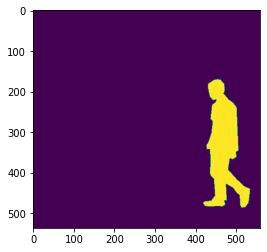

In [5]:
#查看数据
dataset=PennFudanDataset(r'D:\pytorch\pytorch_data\PennFudanPed')
img1=dataset[0][1].get('masks')[1]
print(dataset[0])
plt.imshow(img1)
plt.show()

In [6]:
# 1-Finetuning from a pretrained model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#load a modele pre_trained pre-tained on COCO
model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#print(model) 可查看model参数，该代码块下面内容是调整model相关参数
#replace the classifier with a new one ,that has numclasses which is user-defined
num_classes=2
#get number of input features for the classifier ,从model的属性中一次寻找,直到寻找到cls_score层的 in_features
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

print("in_features:",in_features)

in_features: 1024


In [7]:
# 2-modifying the model to add a different backbone
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# FasterRCNN needs to know the number of  output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),  #5个不同的size
                                   aspect_ratios=((0.5, 1.0, 2.0),))  #3个不同的aspect ratios

# let's define what are the feature maps that we will 
# use to perform the region of interest cropping, as well as the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to be [0]. More generally, 
# the backbone should return an OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
# crop裁剪，感兴趣区域裁剪
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(


In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    print("in_features_mask",in_features_mask)
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [9]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#文件路径传入初始化init中的root对象中，
dataset = PennFudanDataset(r'D:\pytorch\pytorch_data\PennFudanPed', get_transform(train=True))
# dataset的imgs、masks对象中分别包含图片和mask的名称
#DataLoader函数通过PennFudanDataset，读取图片和对应mask，返回的每组images中，含有image，mask，
#返回的targets，为PennFudanDataset函数中所定义的target
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 400, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions
print(predictions)


----------
----------
----------


C:\Python39\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}, {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}]


In [12]:
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

In [16]:
%%time
import torch
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
device = torch.device('cuda') if torch.cuda.is_available() else  detorch.device('cpu')
model.to(device)
model.eval()
x = [torch.rand(3, 300, 600,device=device)]
predictions=model(x)
print(model.roi_heads.box_predictor.cls_score.weight[0]) #输出指定层的weight参数值
#gpu内存溢出，执行以下命令，清楚空闲内存
import gc
gc.collect()

NameError: name 'torchvision' is not defined

In [14]:
dataset_test = PennFudanDataset('D:\pytorch\pytorch_data\PennFudanPed', get_transform(train=False))
print(dataset_test[3][0].shape)



torch.Size([3, 397, 396])


In [15]:
from engine import train_one_epoch, evaluate
import utils
import gc
gc.collect()
torch.cuda.empty_cache()


# train on the GPU or on the CPU, if a GPU is not available
device = 'cpu'#torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('D:\pytorch\pytorch_data\PennFudanPed', get_transform(train=True)) #此步骤已经完成图片读取
dataset_test = PennFudanDataset('D:\pytorch\pytorch_data\PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist() # 随机生成整数数列
dataset = torch.utils.data.Subset(dataset, indices[:-50])  #从读取的dataset集合中，随机提取后50位数据矩阵
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print('this is it')

----------
Epoch: [0]  [ 0/60]  eta: 0:13:07  lr: 0.000090  loss: 3.9883 (3.9883)  loss_classifier: 0.6906 (0.6906)  loss_box_reg: 0.3043 (0.3043)  loss_mask: 2.9753 (2.9753)  loss_objectness: 0.0170 (0.0170)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 13.1238  data: 0.0156  max mem: 862
Epoch: [0]  [10/60]  eta: 0:13:59  lr: 0.000936  loss: 1.7463 (2.3144)  loss_classifier: 0.4276 (0.4500)  loss_box_reg: 0.2849 (0.2876)  loss_mask: 1.2809 (1.5481)  loss_objectness: 0.0170 (0.0234)  loss_rpn_box_reg: 0.0044 (0.0053)  time: 16.7902  data: 0.0355  max mem: 862
Epoch: [0]  [20/60]  eta: 0:11:23  lr: 0.001783  loss: 1.0300 (1.5088)  loss_classifier: 0.2062 (0.3041)  loss_box_reg: 0.2123 (0.2615)  loss_mask: 0.4404 (0.9203)  loss_objectness: 0.0080 (0.0178)  loss_rpn_box_reg: 0.0045 (0.0052)  time: 17.2828  data: 0.0336  max mem: 862
Epoch: [0]  [30/60]  eta: 0:08:42  lr: 0.002629  loss: 0.5395 (1.1977)  loss_classifier: 0.1027 (0.2335)  loss_box_reg: 0.2069 (0.2532)  loss_mask: 0.2059 (0.690

In [28]:
torch.save(model,"D:\objcet_detection.pth")

In [4]:
md=torch.load("D:\objcet_detection.pth")


In [16]:
#gpu执行时会出现内存不足，所以要用CPU进行计算
device = torch.device('cpu')#torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

in_features_mask 256


$$IoU(A, B) = \frac{A \cap B}{A \cup B}$$

True Positive ($TP(c)$): a proposal was made for class $c$ and there actually was an object of class $c$

# 查看模型效果

In [62]:
import torch
import cv2 as cv
from torchvision.transforms.functional import convert_image_dtype
people1 = cv.imread(r'D:\image\5.jpg')
people2 = cv.imread(r'D:\image\6.jpg')
people1=people1.transpose(2,0,1)
people2=people2.transpose(2,0,1)
people1_float=torch.Tensor(people1)
people2_float=torch.Tensor(people2)
people1_uint8=people1_float.to(torch.uint8) 
people2_uint8=people2_float.to(torch.uint8)
batch_int = torch.stack([people2_uint8, people2_uint8])
batch = convert_image_dtype(batch_int, dtype=torch.float)



In [63]:
#img,_=dataset_test[0]
md.eval()  #设置模型为评估模式
with torch.no_grad():
    prediction=md(batch)


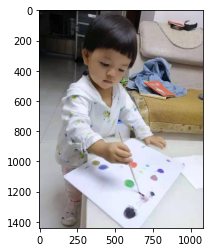

In [66]:
img1=img.mul(255).permute(1,2, 0).byte().numpy()
#Image.fromarray(img.mul(255).permute(1,2, 0).byte().numpy()) #img.mul(255) 把图像转化为0-255整数之间，permute转换图像通道
import matplotlib.pylab as plt
people1 = cv.imread(r'D:\image\6.jpg')
plt.imshow(people1[:,:,::-1])
plt.show()

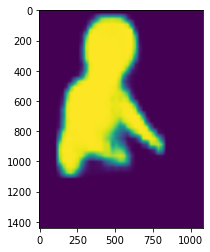

In [67]:
#Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
plt.imshow(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
plt.show()

In [20]:
prediction

[{'boxes': tensor([[ 547.9781,  371.1830, 1009.7372, 1706.0000]]),
  'labels': tensor([1]),
  'scores': tensor([0.9909]),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]])},
 {'boxes': tensor([[ 547.9781,  371.1830, 1009.7372, 1706.0000]]),
  'labels': tensor([1]),
  'scores': tensor([0.9909]),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]])}]

In [3]:
import torchvision
model=torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\wjq-1/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html